In [1]:
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [2]:
warnings.filterwarnings('ignore')

In [3]:
def printVIF(feature_list):
    vif_df = pd.DataFrame()
    vif_df['Features'] = feature_list
    vif_df['VIF'] = [variance_inflation_factor(X_train_sc[feature_list].values, col) for col in range(len(feature_list))]
    return vif_df

In [4]:
bike_df = pd.read_csv('day.csv')
bike_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [5]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
instant       730 non-null int64
dteday        730 non-null object
season        730 non-null int64
yr            730 non-null int64
mnth          730 non-null int64
holiday       730 non-null int64
weekday       730 non-null int64
workingday    730 non-null int64
weathersit    730 non-null int64
temp          730 non-null float64
atemp         730 non-null float64
hum           730 non-null float64
windspeed     730 non-null float64
casual        730 non-null int64
registered    730 non-null int64
cnt           730 non-null int64
dtypes: float64(4), int64(11), object(1)
memory usage: 91.3+ KB


#### No null values.

In [6]:
bike_df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.995890,0.690411,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.000339,0.462641,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


#### Some categorical columns are being treated as numerical columns so we need to change them.

# Dropping irrelevant columns

In [7]:
drop_col = ['instant', 'casual', 'registered']
#instant is index number, does not really affect cnt. 
#Likewise cnt column incorporates casual and registered so we can drop them as well
bike_df.drop(columns = drop_col, axis = 1, inplace = True)
bike_df.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,985
1,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,801
2,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,1600


# Modifying columns and adding dummy variables

In [8]:
bike_df['dteday'] = pd.to_datetime(bike_df['dteday'], format = '%d-%m-%Y')
bike_df.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,2018-01-01,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,985
1,2018-01-02,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,801
2,2018-01-03,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,2018-01-04,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,2018-01-05,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,1600


### Dummy variable for season

In [9]:
season_df = pd.get_dummies(bike_df['season'], drop_first = True)
season_df.columns = ['Summer', 'Fall', 'Winter']
bike_df = pd.concat([bike_df, season_df], axis = 1)
bike_df.drop(columns = ['season'], axis = 1, inplace = True)
bike_df.head()

,dteday,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,Summer,Fall,Winter
0,2018-01-01,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,985,0,0,0
1,2018-01-02,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,801,0,0,0
2,2018-01-03,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,1349,0,0,0
3,2018-01-04,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,1562,0,0,0
4,2018-01-05,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,1600,0,0,0


### Dummy variable for weathersit

In [10]:
weather_df = pd.get_dummies(bike_df['weathersit'])
weather_df.columns = ['Clear', 'Cloudy', 'LightRain']
bike_df = pd.concat([bike_df, weather_df], axis = 1)
bike_df.drop(columns = ['weathersit'], axis = 1, inplace = True)
bike_df.head()

,dteday,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,Summer,Fall,Winter,Clear,Cloudy,LightRain
0,2018-01-01,0,1,0,1,1,14.110847,18.18125,80.5833,10.749882,985,0,0,0,0,1,0
1,2018-01-02,0,1,0,2,1,14.902598,17.68695,69.6087,16.652113,801,0,0,0,0,1,0
2,2018-01-03,0,1,0,3,1,8.050924,9.47025,43.7273,16.636703,1349,0,0,0,1,0,0
3,2018-01-04,0,1,0,4,1,8.200000,10.60610,59.0435,10.739832,1562,0,0,0,1,0,0
4,2018-01-05,0,1,0,5,1,9.305237,11.46350,43.6957,12.522300,1600,0,0,0,1,0,0


### Dummy variable for mnth

In [11]:
mnth_df = pd.get_dummies(bike_df['mnth'], drop_first = True)
mnth_df.columns = ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
bike_df = pd.concat([bike_df, mnth_df], axis = 1)
bike_df.drop(columns = ['mnth'], axis = 1, inplace = True)
bike_df.head()

,dteday,yr,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,...,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,2018-01-01,0,0,1,1,14.110847,18.18125,80.5833,10.749882,985,...,0,0,0,0,0,0,0,0,0,0
1,2018-01-02,0,0,2,1,14.902598,17.68695,69.6087,16.652113,801,...,0,0,0,0,0,0,0,0,0,0
2,2018-01-03,0,0,3,1,8.050924,9.47025,43.7273,16.636703,1349,...,0,0,0,0,0,0,0,0,0,0
3,2018-01-04,0,0,4,1,8.200000,10.60610,59.0435,10.739832,1562,...,0,0,0,0,0,0,0,0,0,0
4,2018-01-05,0,0,5,1,9.305237,11.46350,43.6957,12.522300,1600,...,0,0,0,0,0,0,0,0,0,0


### Dummy variable for weekday

In [12]:
wd_df = pd.get_dummies(bike_df['weekday'], drop_first = True)
wd_df.columns = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
bike_df = pd.concat([bike_df, wd_df], axis = 1)
bike_df.drop(columns = ['weekday'], axis = 1, inplace = True)
bike_df.head()

,dteday,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,Summer,...,Sep,Oct,Nov,Dec,Mon,Tue,Wed,Thu,Fri,Sat
0,2018-01-01,0,0,1,14.110847,18.18125,80.5833,10.749882,985,0,...,0,0,0,0,1,0,0,0,0,0
1,2018-01-02,0,0,1,14.902598,17.68695,69.6087,16.652113,801,0,...,0,0,0,0,0,1,0,0,0,0
2,2018-01-03,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,0,...,0,0,0,0,0,0,1,0,0,0
3,2018-01-04,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,0,...,0,0,0,0,0,0,0,1,0,0
4,2018-01-05,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,0,...,0,0,0,0,0,0,0,0,1,0


In [13]:
#Simply renaming columns and changing order
bike_df = bike_df.reindex(columns = ['dteday', 'yr', 'workingday', 'holiday', 'Summer', 'Fall', 'Winter', 'Clear', 'Cloudy', \
                                     'LightRain', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', \
                                     'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'temp', 'atemp', 'hum', 'windspeed', 'cnt'])

bike_df.columns = ['DteDay', 'Yr', 'WorkingDay', 'Holiday', 'Summer', 'Fall', 'Winter', 'Clear', 'Cloudy', 'LightRain', 'Feb', 
                   'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', \
                   'Sat', 'Temp', 'ATemp', 'Hum', 'WindSpeed', 'Cnt']

bike_df.head()

,DteDay,Yr,WorkingDay,Holiday,Summer,Fall,Winter,Clear,Cloudy,LightRain,...,Tue,Wed,Thu,Fri,Sat,Temp,ATemp,Hum,WindSpeed,Cnt
0,2018-01-01,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,14.110847,18.18125,80.5833,10.749882,985
1,2018-01-02,0,1,0,0,0,0,0,1,0,...,1,0,0,0,0,14.902598,17.68695,69.6087,16.652113,801
2,2018-01-03,0,1,0,0,0,0,1,0,0,...,0,1,0,0,0,8.050924,9.47025,43.7273,16.636703,1349
3,2018-01-04,0,1,0,0,0,0,1,0,0,...,0,0,1,0,0,8.200000,10.60610,59.0435,10.739832,1562
4,2018-01-05,0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,9.305237,11.46350,43.6957,12.522300,1600


# Exploratory Data Analysis

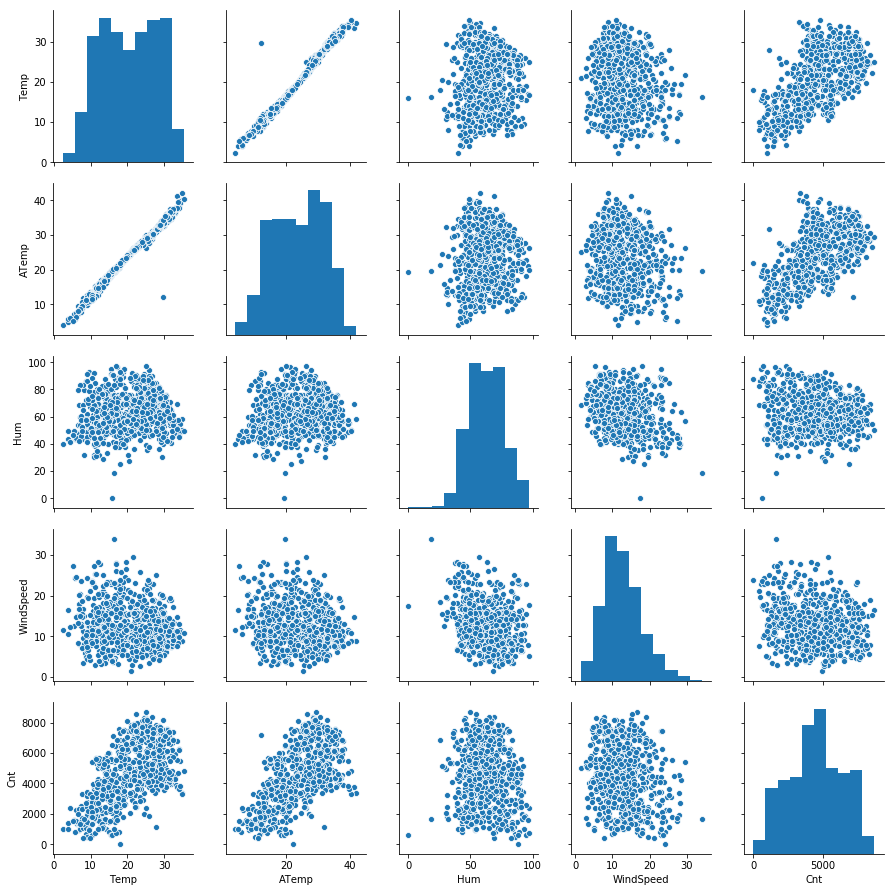

In [14]:
sns.pairplot(bike_df[['Temp', 'ATemp', 'Hum', 'WindSpeed', 'Cnt']])
plt.show()

### Points to Note
   - Cnt(target variable) has somewhat of a linear relation with Temp and ATemp.
   - Temp and ATemp columns present perfectly linear relationship(will contribute to multicollinearity).

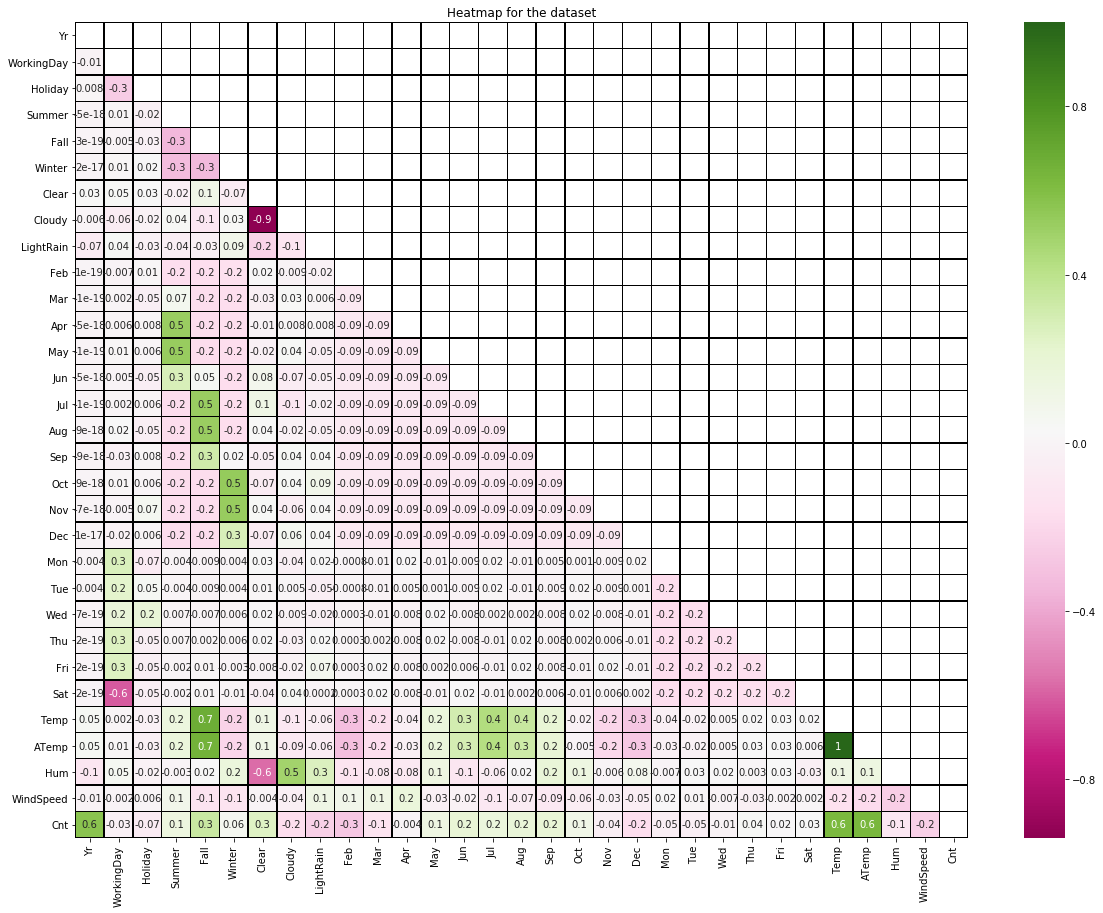

In [15]:
corr_df = bike_df.corr()
plt.figure(figsize = (20, 15))
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_df, cmap = 'PiYG', mask = mask, linewidths = 0.3, linecolor = 'black', fmt = '.1g', annot = True)
plt.title('Heatmap for the dataset')
plt.show()

### Points to Note
   - Cnt(target variable) has highest correlation between Temp, ATemp, Yr, Clear and Fall.
   - Temp and ATemp have high correlation therefore they will contribute to multicollinearity.
   - WorkingDay is highly correlated with Mon/Tue/Wed/Thu/Fri/Sat.
   - Different months are highly correlated with different seasons, for eg Apr/May with Summer, Jul/Aug with Fall.
   - Temp and ATemp are highly correlated with all other features.

In [16]:
#Removing column DteDay
bike_df.drop(columns = ['DteDay'], axis = 1, inplace = True)

# Train-Test Split, Scaling the variables and building the model

In [17]:
y = bike_df.pop('Cnt').values.reshape((-1, 1))
X = bike_df
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 100)

In [18]:
scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [19]:
X_train_sc = pd.DataFrame(X_train_sc)
X_train_sc.columns = X_train.columns
X_test_sc = pd.DataFrame(X_test_sc)
X_test_sc.columns = X_test.columns

# Model 1: Only using Temp(feature)

In [20]:
X_train_sm = sm.add_constant(X_train_sc['Temp'])
lr_m1 = sm.OLS(y_train, X_train_sm).fit()
print(lr_m1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     362.0
Date:                Sun, 27 Dec 2020   Prob (F-statistic):           2.46e-61
Time:                        15:23:04   Log-Likelihood:                -4449.7
No. Observations:                 510   AIC:                             8903.
Df Residuals:                     508   BIC:                             8912.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1491.2143    170.676      8.737      0.0

### R-squared is 0.416 and the p value of Temp is also close to 0 which means the feature is statistically significant. Let us procees with this model and add more features.

# Model 2: Adding Yr(feature) to Model 1

In [21]:
X_train_sm = sm.add_constant(X_train_sc[['Temp', 'Yr']])
lr_m2 = sm.OLS(y_train, X_train_sm).fit()
print(lr_m2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     568.2
Date:                Sun, 27 Dec 2020   Prob (F-statistic):          3.34e-130
Time:                        15:23:04   Log-Likelihood:                -4287.0
No. Observations:                 510   AIC:                             8580.
Df Residuals:                     507   BIC:                             8593.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        710.9783    129.481      5.491      0.0

### Significant improvement in R-Squared and both the features(Temp and Yr) are statistically significant. Adding more features to this model.

# Model 3: Adding Fall(feature) to Model 2

In [22]:
X_train_sm = sm.add_constant(X_train_sc[['Temp', 'Yr', 'Fall']])
lr_m3 = sm.OLS(y_train, X_train_sm).fit()
print(lr_m3.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     391.2
Date:                Sun, 27 Dec 2020   Prob (F-statistic):          2.24e-131
Time:                        15:23:05   Log-Likelihood:                -4280.9
No. Observations:                 510   AIC:                             8570.
Df Residuals:                     506   BIC:                             8587.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        470.5627    145.476      3.235      0.0

### The R-squared does not show much improvement and the p value of Fall is also close to 0. Let us build on this model and add all the features now.

# Model 4: Using all the features

In [23]:
X_train_sm = sm.add_constant(X_train_sc)
lr_m4 = sm.OLS(y_train, X_train_sm).fit()
print(lr_m4.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     93.97
Date:                Sun, 27 Dec 2020   Prob (F-statistic):          1.24e-177
Time:                        15:23:05   Log-Likelihood:                -4102.7
No. Observations:                 510   AIC:                             8265.
Df Residuals:                     480   BIC:                             8392.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        892.2648    228.279      3.909      0.0

## Calculating VIF

In [24]:
features = X_train_sc.columns
vif_df = printVIF(features)
vif_df.sort_values(by = 'VIF', ascending = False)

,Features,VIF
26,Temp,66.833327
1,WorkingDay,66.332450
27,ATemp,55.814711
20,Mon,42.923188
21,Tue,42.042971
24,Fri,41.086810
23,Thu,40.364884
22,Wed,37.420422
6,Clear,36.529126
7,Cloudy,26.101647


### Dropping Tue since it has high pvalue and high VIF.

# Model 5: Dropping Tue(feature) from Model 4

In [25]:
features = ['Yr', 'WorkingDay', 'Holiday', 'Summer', 'Fall', 'Winter', 'Clear', 'Cloudy', 'LightRain', 'Feb', 'Mar', 'Apr', \
            'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Mon', 'Wed', 'Thu', 'Fri', 'Sat', 'Temp', 'ATemp', \
            'Hum', 'WindSpeed']
X_train_sm = sm.add_constant(X_train_sc[features])
lr_m5 = sm.OLS(y_train, X_train_sm).fit()
print(lr_m5.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     97.50
Date:                Sun, 27 Dec 2020   Prob (F-statistic):          1.31e-178
Time:                        15:23:06   Log-Likelihood:                -4102.8
No. Observations:                 510   AIC:                             8264.
Df Residuals:                     481   BIC:                             8386.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        891.3939    228.053      3.909      0.0

## Calculating VIF

In [26]:
vif_df = printVIF(features)
vif_df.sort_values(by = 'VIF', ascending = False)

,Features,VIF
25,Temp,66.794956
26,ATemp,55.805000
6,Clear,36.524368
7,Cloudy,26.098792
4,Fall,11.337894
15,Aug,9.929908
14,Jul,8.888160
5,Winter,8.174644
13,Jun,6.964056
3,Summer,6.758101


### Dropping Mon since it has high pvalue.

# Model 6: Dropping Mon(feature) from Model 5

In [27]:
features = ['Yr', 'WorkingDay', 'Holiday', 'Summer', 'Fall', 'Winter', 'Clear', 'Cloudy', 'LightRain', 'Feb', 'Mar', 'Apr', \
            'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Wed', 'Thu', 'Fri', 'Sat', 'Temp', 'ATemp', 'Hum', \
            'WindSpeed']
X_train_sm = sm.add_constant(X_train_sc[features])
lr_m6 = sm.OLS(y_train, X_train_sm).fit()
print(lr_m6.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     101.3
Date:                Sun, 27 Dec 2020   Prob (F-statistic):          1.30e-179
Time:                        15:23:07   Log-Likelihood:                -4102.8
No. Observations:                 510   AIC:                             8262.
Df Residuals:                     482   BIC:                             8380.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        893.6588    227.121      3.935      0.0

## Calculating VIF

In [28]:
vif_df = printVIF(features)
vif_df.sort_values(by = 'VIF', ascending = False)

,Features,VIF
24,Temp,66.789462
25,ATemp,55.804581
6,Clear,36.333702
7,Cloudy,25.978089
4,Fall,11.326690
15,Aug,9.903373
14,Jul,8.879238
5,Winter,8.145070
13,Jun,6.958142
3,Summer,6.757705


### Dropping ATemp since it has high pvalue and high VIF.

# Model 7: Dropping ATemp(feature) from Model 6

In [29]:
features = ['Yr', 'WorkingDay', 'Holiday', 'Summer', 'Fall', 'Winter', 'Clear', 'Cloudy', 'LightRain', 'Feb', 'Mar', 'Apr', \
            'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Wed', 'Thu', 'Fri', 'Sat', 'Temp', 'Hum', 'WindSpeed']
X_train_sm = sm.add_constant(X_train_sc[features])
lr_m7 = sm.OLS(y_train, X_train_sm).fit()
print(lr_m7.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     105.4
Date:                Sun, 27 Dec 2020   Prob (F-statistic):          1.35e-180
Time:                        15:23:08   Log-Likelihood:                -4102.9
No. Observations:                 510   AIC:                             8260.
Df Residuals:                     483   BIC:                             8374.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        894.7508    226.904      3.943      0.0

## Calculating VIF

In [30]:
vif_df = printVIF(features)
vif_df.sort_values(by = 'VIF', ascending = False)

,Features,VIF
6,Clear,36.287955
7,Cloudy,25.957564
4,Fall,11.307659
15,Aug,9.816840
14,Jul,8.854383
5,Winter,8.145041
24,Temp,7.106392
13,Jun,6.921668
3,Summer,6.756586
16,Sep,6.711620


### Dropping Sat since it has high pvalue.

# Model 8: Dropping Sat(feature) from Model 7

In [31]:
features = ['Yr', 'WorkingDay', 'Holiday', 'Summer', 'Fall', 'Winter', 'Clear', 'Cloudy', 'LightRain', 'Feb', 'Mar', 'Apr', \
            'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Wed', 'Thu', 'Fri', 'Temp', 'Hum', 'WindSpeed']
X_train_sm = sm.add_constant(X_train_sc[features])
lr_m8 = sm.OLS(y_train, X_train_sm).fit()
print(lr_m8.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     109.8
Date:                Sun, 27 Dec 2020   Prob (F-statistic):          1.41e-181
Time:                        15:23:08   Log-Likelihood:                -4103.0
No. Observations:                 510   AIC:                             8258.
Df Residuals:                     484   BIC:                             8368.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        871.4304    220.547      3.951      0.0

## Calculating VIF

In [32]:
vif_df = printVIF(features)
vif_df.sort_values(by = 'VIF', ascending = False)

,Features,VIF
6,Clear,33.869286
7,Cloudy,24.703359
4,Fall,11.293843
15,Aug,9.813994
14,Jul,8.854383
5,Winter,8.136765
23,Temp,7.103922
13,Jun,6.921645
3,Summer,6.754580
16,Sep,6.710518


### Dropping Nov since it has high pvalue.

# Model 9: Dropping Nov(feature) from Model 8

In [33]:
features = ['Yr', 'WorkingDay', 'Holiday', 'Summer', 'Fall', 'Winter', 'Clear', 'Cloudy', 'LightRain', 'Feb', 'Mar', 'Apr', \
            'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Dec', 'Wed', 'Thu', 'Fri', 'Temp', 'Hum', 'WindSpeed']
X_train_sm = sm.add_constant(X_train_sc[features])
lr_m9 = sm.OLS(y_train, X_train_sm).fit()
print(lr_m9.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     114.5
Date:                Sun, 27 Dec 2020   Prob (F-statistic):          1.68e-182
Time:                        15:23:11   Log-Likelihood:                -4103.2
No. Observations:                 510   AIC:                             8256.
Df Residuals:                     485   BIC:                             8362.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        886.7153    219.399      4.042      0.0

## Calculating VIF

In [34]:
vif_df = printVIF(features)
vif_df.sort_values(by = 'VIF', ascending = False)

,Features,VIF
6,Clear,33.470637
7,Cloudy,24.502699
4,Fall,9.746303
15,Aug,7.199285
22,Temp,6.822049
14,Jul,6.590821
3,Summer,6.411994
12,May,5.516622
13,Jun,5.469504
11,Apr,4.448003


### Dropping Dec since it has high pvalue.

# Model 10: Dropping Dec(feature) from Model 9

In [35]:
features = ['Yr', 'WorkingDay', 'Holiday', 'Summer', 'Fall', 'Winter', 'Clear', 'Cloudy', 'LightRain', 'Feb', 'Mar', 'Apr', \
            'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Wed', 'Thu', 'Fri', 'Temp', 'Hum', 'WindSpeed']
X_train_sm = sm.add_constant(X_train_sc[features])
lr_m10 = sm.OLS(y_train, X_train_sm).fit()
print(lr_m10.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     119.6
Date:                Sun, 27 Dec 2020   Prob (F-statistic):          1.59e-183
Time:                        15:23:12   Log-Likelihood:                -4103.3
No. Observations:                 510   AIC:                             8255.
Df Residuals:                     486   BIC:                             8356.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        892.2621    218.506      4.083      0.0

## Calculating VIF

In [36]:
vif_df = printVIF(features)
vif_df.sort_values(by = 'VIF', ascending = False)

,Features,VIF
6,Clear,33.063249
7,Cloudy,24.342554
4,Fall,9.712572
15,Aug,7.005932
21,Temp,6.822017
14,Jul,6.437379
3,Summer,6.406270
12,May,5.395452
13,Jun,5.349614
11,Apr,4.354398


### Dropping Jul since it has high pvalue.

# Model 11: Dropping Jul(feature) from Model 10

In [37]:
features = ['Yr', 'WorkingDay', 'Holiday', 'Summer', 'Fall', 'Winter', 'Clear', 'Cloudy', 'LightRain', 'Feb', 'Mar', 'Apr', \
            'May', 'Jun', 'Aug', 'Sep', 'Oct', 'Wed', 'Thu', 'Fri', 'Temp', 'Hum', 'WindSpeed']
X_train_sm = sm.add_constant(X_train_sc[features])
lr_m11 = sm.OLS(y_train, X_train_sm).fit()
print(lr_m11.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     125.3
Date:                Sun, 27 Dec 2020   Prob (F-statistic):          1.57e-184
Time:                        15:23:13   Log-Likelihood:                -4103.4
No. Observations:                 510   AIC:                             8253.
Df Residuals:                     487   BIC:                             8350.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        892.1139    218.331      4.086      0.0

## Calculating VIF

In [38]:
vif_df = printVIF(features)
vif_df.sort_values(by = 'VIF', ascending = False)

,Features,VIF
6,Clear,33.039316
7,Cloudy,24.342513
4,Fall,7.219605
3,Summer,5.751027
20,Temp,4.523180
8,LightRain,3.661336
12,May,3.515986
11,Apr,3.179384
5,Winter,2.979624
13,Jun,2.382415


### Dropping Feb since it has high pvalue.

# Model 12: Dropping Feb(feature) from Model 11

In [39]:
features = ['Yr', 'WorkingDay', 'Holiday', 'Summer', 'Fall', 'Winter', 'Clear', 'Cloudy', 'LightRain', 'Mar', 'Apr', 'May', \
            'Jun', 'Aug', 'Sep', 'Oct', 'Wed', 'Thu', 'Fri', 'Temp', 'Hum', 'WindSpeed']
X_train_sm = sm.add_constant(X_train_sc[features])
lr_m12 = sm.OLS(y_train, X_train_sm).fit()
print(lr_m12.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     131.2
Date:                Sun, 27 Dec 2020   Prob (F-statistic):          2.32e-185
Time:                        15:23:14   Log-Likelihood:                -4104.0
No. Observations:                 510   AIC:                             8252.
Df Residuals:                     488   BIC:                             8345.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        941.6798    213.116      4.419      0.0

## Calculating VIF

In [40]:
vif_df = printVIF(features)
vif_df.sort_values(by = 'VIF', ascending = False)

,Features,VIF
6,Clear,31.178511
7,Cloudy,23.263517
4,Fall,6.658919
3,Summer,5.656653
19,Temp,4.514254
8,LightRain,3.536337
11,May,3.425365
10,Apr,3.085376
5,Winter,2.448034
12,Jun,2.335553


### Dropping Wed since it has high pvalue.

# Model 13: Dropping Wed(feature) from Model 12

In [41]:
features = ['Yr', 'WorkingDay', 'Holiday', 'Summer', 'Fall', 'Winter', 'Clear', 'Cloudy', 'LightRain', 'Mar', 'Apr', 'May', \
            'Jun', 'Aug', 'Sep', 'Oct', 'Thu', 'Fri', 'Temp', 'Hum', 'WindSpeed']
X_train_sm = sm.add_constant(X_train_sc[features])
lr_m13 = sm.OLS(y_train, X_train_sm).fit()
print(lr_m13.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     137.5
Date:                Sun, 27 Dec 2020   Prob (F-statistic):          3.87e-186
Time:                        15:23:14   Log-Likelihood:                -4104.7
No. Observations:                 510   AIC:                             8251.
Df Residuals:                     489   BIC:                             8340.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        953.3572    212.966      4.477      0.0

## Calculating VIF

In [42]:
vif_df = printVIF(features)
vif_df.sort_values(by = 'VIF', ascending = False)

,Features,VIF
6,Clear,31.122534
7,Cloudy,23.214233
4,Fall,6.658798
3,Summer,5.656313
18,Temp,4.510933
8,LightRain,3.529409
11,May,3.422239
10,Apr,3.085339
5,Winter,2.447459
12,Jun,2.335536


### Dropping Apr since it has high pvalue.

# Model 14: Dropping Apr(feature) from Model 13

In [43]:
features = ['Yr', 'WorkingDay', 'Holiday', 'Summer', 'Fall', 'Winter', 'Clear', 'Cloudy', 'LightRain', 'Mar', 'May', 'Jun', \
            'Aug', 'Sep', 'Oct', 'Thu', 'Fri', 'Temp', 'Hum', 'WindSpeed']
X_train_sm = sm.add_constant(X_train_sc[features])
lr_m14 = sm.OLS(y_train, X_train_sm).fit()
print(lr_m14.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     144.2
Date:                Sun, 27 Dec 2020   Prob (F-statistic):          1.09e-186
Time:                        15:23:15   Log-Likelihood:                -4106.0
No. Observations:                 510   AIC:                             8252.
Df Residuals:                     490   BIC:                             8337.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        976.5695    212.784      4.589      0.0

## Calculating VIF

In [44]:
vif_df = printVIF(features)
vif_df.sort_values(by = 'VIF', ascending = False)

,Features,VIF
6,Clear,30.942406
7,Cloudy,23.102627
4,Fall,6.657646
17,Temp,4.479282
8,LightRain,3.518431
3,Summer,2.882950
5,Winter,2.410715
18,Hum,1.964907
10,May,1.839285
12,Aug,1.780090


### Dropping Jun since it has high pvalue.

# Model 15: Dropping Jun(feature) from Model 14

In [45]:
features = ['Yr', 'WorkingDay', 'Holiday', 'Summer', 'Fall', 'Winter', 'Clear', 'Cloudy', 'LightRain', 'Mar', 'May', 'Aug', \
            'Sep', 'Oct', 'Thu', 'Fri', 'Temp', 'Hum', 'WindSpeed']
X_train_sm = sm.add_constant(X_train_sc[features])
lr_m15 = sm.OLS(y_train, X_train_sm).fit()
print(lr_m15.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     152.0
Date:                Sun, 27 Dec 2020   Prob (F-statistic):          1.77e-187
Time:                        15:23:16   Log-Likelihood:                -4106.7
No. Observations:                 510   AIC:                             8251.
Df Residuals:                     491   BIC:                             8332.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        973.7217    212.861      4.574      0.0

## Calculating VIF

In [46]:
vif_df = printVIF(features)
vif_df.sort_values(by = 'VIF', ascending = False)

,Features,VIF
6,Clear,30.931328
7,Cloudy,23.101881
4,Fall,6.496195
16,Temp,3.843418
8,LightRain,3.518142
3,Summer,2.835839
5,Winter,2.366069
17,Hum,1.948712
11,Aug,1.680251
10,May,1.558283


### Dropping May since it has high pvalue.

# Model 16: Dropping May(feature) from Model 15

In [47]:
features = ['Yr', 'WorkingDay', 'Holiday', 'Summer', 'Fall', 'Winter', 'Clear', 'Cloudy', 'LightRain', 'Mar', 'Aug', 'Sep', \
            'Oct', 'Thu', 'Fri', 'Temp', 'Hum', 'WindSpeed']
X_train_sm = sm.add_constant(X_train_sc[features])
lr_m16 = sm.OLS(y_train, X_train_sm).fit()
print(lr_m16.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     160.4
Date:                Sun, 27 Dec 2020   Prob (F-statistic):          4.24e-188
Time:                        15:23:17   Log-Likelihood:                -4107.9
No. Observations:                 510   AIC:                             8252.
Df Residuals:                     492   BIC:                             8328.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        937.5892    211.780      4.427      0.0

## Calculating VIF

In [48]:
vif_df = printVIF(features)
vif_df.sort_values(by = 'VIF', ascending = False)

,Features,VIF
6,Clear,30.516161
7,Cloudy,22.854333
4,Fall,6.297469
15,Temp,3.726202
8,LightRain,3.480333
3,Summer,2.671586
5,Winter,2.328970
16,Hum,1.915861
10,Aug,1.679795
12,Oct,1.518278


### Dropping Fall since it has high pvalue.

# Model 17: Dropping Fall(feature) from Model 16

In [49]:
features = ['Yr', 'WorkingDay', 'Holiday', 'Summer', 'Winter', 'Clear', 'Cloudy', 'LightRain', 'Mar', 'Aug', 'Sep', 'Oct', \
            'Thu', 'Fri', 'Temp', 'Hum', 'WindSpeed']
X_train_sm = sm.add_constant(X_train_sc[features])
lr_m17 = sm.OLS(y_train, X_train_sm).fit()
print(lr_m17.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     169.6
Date:                Sun, 27 Dec 2020   Prob (F-statistic):          1.30e-188
Time:                        15:23:19   Log-Likelihood:                -4109.4
No. Observations:                 510   AIC:                             8253.
Df Residuals:                     493   BIC:                             8325.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        953.3340    211.963      4.498      0.0

## Calculating VIF

In [50]:
vif_df = printVIF(features)
vif_df.sort_values(by = 'VIF', ascending = False)

,Features,VIF
5,Clear,30.515184
6,Cloudy,22.836690
7,LightRain,3.460269
15,Hum,1.876240
4,Winter,1.779628
14,Temp,1.631170
11,Oct,1.489858
9,Aug,1.461959
3,Summer,1.387070
1,WorkingDay,1.288121


### Dropping Mar since it has high pvalue.

# Model 18: Dropping Mar(feature) from Model 17

In [51]:
features = ['Yr', 'WorkingDay', 'Holiday', 'Summer', 'Winter', 'Clear', 'Cloudy', 'LightRain', 'Aug', 'Sep', 'Oct', 'Thu', \
            'Fri', 'Temp', 'Hum', 'WindSpeed']
X_train_sm = sm.add_constant(X_train_sc[features])
lr_m18 = sm.OLS(y_train, X_train_sm).fit()
print(lr_m18.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     180.3
Date:                Sun, 27 Dec 2020   Prob (F-statistic):          2.92e-189
Time:                        15:23:19   Log-Likelihood:                -4110.5
No. Observations:                 510   AIC:                             8253.
Df Residuals:                     494   BIC:                             8321.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        995.6520    210.354      4.733      0.0

## Calculating VIF

In [52]:
vif_df = printVIF(features)
vif_df.sort_values(by = 'VIF', ascending = False)

,Features,VIF
5,Clear,29.876629
6,Cloudy,22.476624
7,LightRain,3.415075
14,Hum,1.875614
4,Winter,1.712072
13,Temp,1.593919
10,Oct,1.489612
8,Aug,1.454251
3,Summer,1.387047
1,WorkingDay,1.286454


### Dropping Fri since it has high pvalue.

# Model 19: Dropping Fri(feature) from Model 18

In [53]:
features = ['Yr', 'WorkingDay', 'Holiday', 'Summer', 'Winter', 'Clear', 'Cloudy', 'LightRain', 'Aug', 'Sep', 'Oct', 'Thu', \
            'Temp', 'Hum', 'WindSpeed']
X_train_sm = sm.add_constant(X_train_sc[features])
lr_m19 = sm.OLS(y_train, X_train_sm).fit()
print(lr_m19.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     192.1
Date:                Sun, 27 Dec 2020   Prob (F-statistic):          1.05e-189
Time:                        15:23:20   Log-Likelihood:                -4112.2
No. Observations:                 510   AIC:                             8254.
Df Residuals:                     495   BIC:                             8318.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1002.9542    210.800      4.758      0.0

## Calculating VIF

In [54]:
vif_df = printVIF(features)
vif_df.sort_values(by = 'VIF', ascending = False)

,Features,VIF
5,Clear,29.876105
6,Cloudy,22.476608
7,LightRain,3.408011
13,Hum,1.875420
4,Winter,1.711761
12,Temp,1.593902
10,Oct,1.484009
8,Aug,1.454236
3,Summer,1.386338
9,Sep,1.242542


### Dropping Thu since it has high pvalue.

# Model 20: Dropping Thu(feature) from Model 19

In [55]:
features = ['Yr', 'WorkingDay', 'Holiday', 'Summer', 'Winter', 'Clear', 'Cloudy', 'LightRain', 'Aug', 'Sep', 'Oct', 'Temp', \
            'Hum', 'WindSpeed']
X_train_sm = sm.add_constant(X_train_sc[features])
lr_m20 = sm.OLS(y_train, X_train_sm).fit()
print(lr_m20.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     205.9
Date:                Sun, 27 Dec 2020   Prob (F-statistic):          3.02e-190
Time:                        15:23:22   Log-Likelihood:                -4113.7
No. Observations:                 510   AIC:                             8255.
Df Residuals:                     496   BIC:                             8315.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1002.8341    211.202      4.748      0.0

## Calculating VIF

In [56]:
vif_df = printVIF(features)
vif_df.sort_values(by = 'VIF', ascending = False)

,Features,VIF
5,Clear,29.865717
6,Cloudy,22.474545
7,LightRain,3.406659
12,Hum,1.872466
4,Winter,1.711141
11,Temp,1.590149
10,Oct,1.483844
8,Aug,1.454227
3,Summer,1.383988
9,Sep,1.242263


### Dropping Clear since it has high VIF.

# Model 21: Dropping Clear(feature) from Model 20

In [57]:
features = ['Yr', 'WorkingDay', 'Holiday', 'Summer', 'Winter', 'Cloudy', 'LightRain', 'Aug', 'Sep', 'Oct', 'Temp', 'Hum', \
            'WindSpeed']
X_train_sm = sm.add_constant(X_train_sc[features])
lr_m21 = sm.OLS(y_train, X_train_sm).fit()
print(lr_m21.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     205.9
Date:                Sun, 27 Dec 2020   Prob (F-statistic):          3.02e-190
Time:                        15:23:22   Log-Likelihood:                -4113.7
No. Observations:                 510   AIC:                             8255.
Df Residuals:                     496   BIC:                             8315.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2194.9997    239.086      9.181      0.0

## Calculating VIF

In [58]:
vif_df = printVIF(features)
vif_df.sort_values(by = 'VIF', ascending = False)

,Features,VIF
11,Hum,16.412884
10,Temp,9.885734
12,WindSpeed,3.682422
1,WorkingDay,3.622772
4,Winter,2.254015
5,Cloudy,2.204362
0,Yr,2.019342
3,Summer,1.836323
7,Aug,1.599673
9,Oct,1.596855


### Dropping Hum since it has high VIF.

# Model 22: Dropping Hum(feature) from Model 21

In [59]:
features = ['Yr', 'WorkingDay', 'Holiday', 'Summer', 'Winter', 'Cloudy', 'LightRain', 'Aug', 'Sep', 'Oct', 'Temp', 'WindSpeed']
X_train_sm = sm.add_constant(X_train_sc[features])
lr_m22 = sm.OLS(y_train, X_train_sm).fit()
print(lr_m22.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     212.1
Date:                Sun, 27 Dec 2020   Prob (F-statistic):          1.03e-186
Time:                        15:23:24   Log-Likelihood:                -4124.9
No. Observations:                 510   AIC:                             8276.
Df Residuals:                     497   BIC:                             8331.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1335.1954    157.993      8.451      0.0

## Calculating VIF

In [60]:
vif_df = printVIF(features)
vif_df.sort_values(by = 'VIF', ascending = False)

,Features,VIF
10,Temp,5.796279
11,WindSpeed,3.392962
1,WorkingDay,3.174020
0,Yr,2.012889
4,Winter,2.005701
3,Summer,1.831334
7,Aug,1.594506
9,Oct,1.591675
5,Cloudy,1.492847
8,Sep,1.337759


### Dropping Oct since it has high pvalue.

# Model 23: Dropping Oct(feature) from Model 22

In [61]:
features = ['Yr', 'WorkingDay', 'Holiday', 'Summer', 'Winter', 'Cloudy', 'LightRain', 'Aug', 'Sep', 'Temp', 'WindSpeed']
X_train_sm = sm.add_constant(X_train_sc[features])
lr_m23 = sm.OLS(y_train, X_train_sm).fit()
print(lr_m23.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     230.1
Date:                Sun, 27 Dec 2020   Prob (F-statistic):          3.03e-187
Time:                        15:23:25   Log-Likelihood:                -4126.5
No. Observations:                 510   AIC:                             8277.
Df Residuals:                     498   BIC:                             8328.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1301.6726    157.147      8.283      0.0

## Calculating VIF

In [62]:
vif_df = printVIF(features)
vif_df.sort_values(by = 'VIF', ascending = False)

,Features,VIF
9,Temp,5.666950
10,WindSpeed,3.390076
1,WorkingDay,3.165177
0,Yr,2.008973
3,Summer,1.820776
7,Aug,1.583112
4,Winter,1.541002
5,Cloudy,1.492218
8,Sep,1.307573
2,Holiday,1.084458


### Dropping WorkingDay since it has high pvalue.

# Model 24: Dropping WorkingDay(feature) from Model 23

In [63]:
features = ['Yr', 'Holiday', 'Summer', 'Winter', 'Cloudy', 'LightRain', 'Aug', 'Sep', 'Temp', 'WindSpeed']
X_train_sm = sm.add_constant(X_train_sc[features])
lr_m24 = sm.OLS(y_train, X_train_sm).fit()
print(lr_m24.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     250.5
Date:                Sun, 27 Dec 2020   Prob (F-statistic):          2.62e-187
Time:                        15:23:25   Log-Likelihood:                -4129.2
No. Observations:                 510   AIC:                             8280.
Df Residuals:                     499   BIC:                             8327.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1158.2383    144.984      7.989      0.0

## Calculating VIF

In [64]:
vif_df = printVIF(features)
vif_df.sort_values(by = 'VIF', ascending = False)

,Features,VIF
8,Temp,5.012840
9,WindSpeed,3.103226
0,Yr,2.000292
2,Summer,1.815872
6,Aug,1.581198
4,Cloudy,1.491031
3,Winter,1.483394
7,Sep,1.307124
5,LightRain,1.081314
1,Holiday,1.036152


## Choosing Model 24

In [65]:
y_train_predict = lr_m24.predict(X_train_sm).values.reshape((-1, 1))
r2_trn = r2_score(y_train, y_train_predict)
print('R-Squared for Train Dataset:', r2_trn)

R-Squared for Train Dataset: 0.8338606244120907


# Residual Analysis

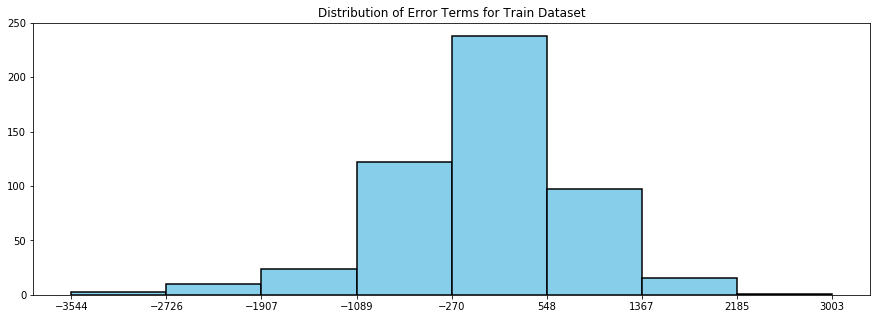

In [66]:
res_train = y_train - y_train_predict
plt.figure(figsize = (15, 5))
plt.title('Distribution of Error Terms for Train Dataset')
_, bins, _ = plt.hist(res_train, bins = 8, color = 'skyblue', edgecolor = 'black', linewidth = 1.5)
plt.xticks(bins)
plt.show()

#### The error terms are normally distributed.

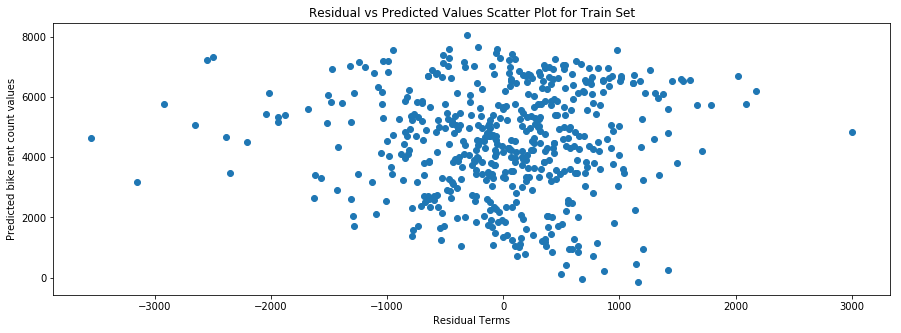

In [67]:
plt.figure(figsize = (15, 5))
plt.title('Residual vs Predicted Values Scatter Plot for Train Set')
plt.xlabel('Residual Terms')
plt.ylabel('Predicted bike rent count values')
plt.scatter(res_train, y_train_predict)
plt.show()

#### There is no pattern in the residual and predicted values, hence homoscedasticity holds.

In [68]:
rse_trn = np.sqrt(mean_squared_error(y_train, y_train_predict))
print('RSE for Train Dataset:', rse_trn)

RSE for Train Dataset: 794.3154712723688


# Let us finalize model 24 (R-squared = 0.834).

# Making predictions on the test set

In [69]:
X_test_sm = sm.add_constant(X_test_sc[features])
y_test_predict = lr_m24.predict(X_test_sm).values.reshape((-1, 1))
r2_tst = r2_score(y_test, y_test_predict)
print('R-Squared for Test Dataset:', r2_tst)

R-Squared for Test Dataset: 0.7935224695104377


In [70]:
rse_tst = np.sqrt(mean_squared_error(y_test, y_test_predict))
print('RSE for Test Dataset:', rse_tst)

RSE for Test Dataset: 863.6443263359793


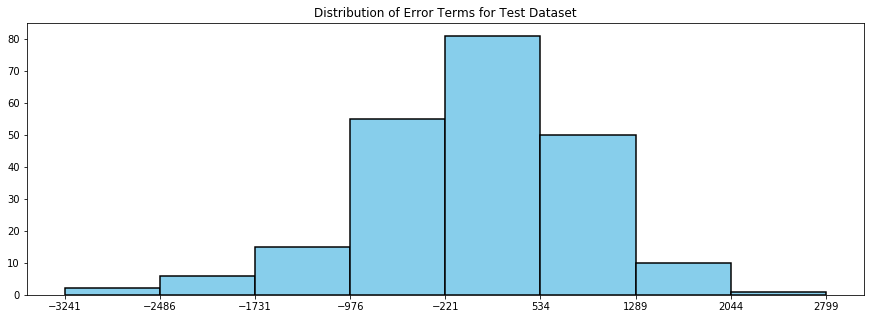

In [71]:
res_test = y_test - y_test_predict
plt.figure(figsize = (15, 5))
plt.title('Distribution of Error Terms for Test Dataset')
_, bins, _ = plt.hist(res_test, bins = 8, color = 'skyblue', edgecolor = 'black', linewidth = 1.5)
plt.xticks(bins)
plt.show()

#### The error terms are normally distributed.

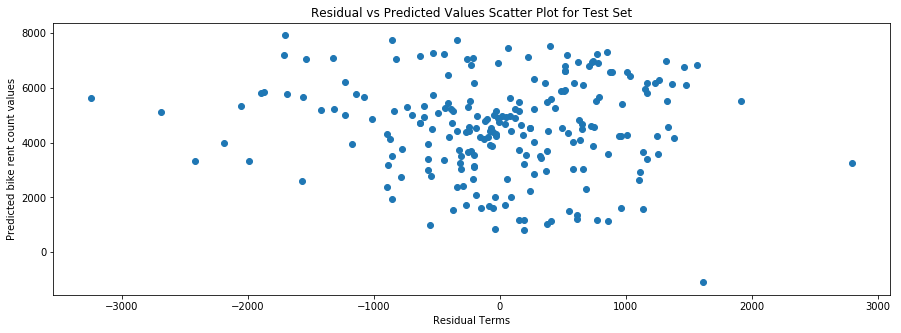

In [72]:
plt.figure(figsize = (15, 5))
plt.title('Residual vs Predicted Values Scatter Plot for Test Set')
plt.xlabel('Residual Terms')
plt.ylabel('Predicted bike rent count values')
plt.scatter(res_test, y_test_predict)
plt.show()

#### There is no pattern in the residual and predicted values, hence homoscedasticity holds.

### The R-squared for the test dataset is close to the train dataset. Also, the error terms are normally distributed and homoscedasticity holds therefore we can use this model to understand how various independent factors affect the count of bikes on a single day.

# Final Model Equation

Cnt = 1158.2383 + (4496.6820 * Temp) + (2021.4376 * Yr) + (1191.5878 * Winter) + (1010.8056 * Sep) + (879.7754 * Summer) +  (470.5913 * Aug) - (705.2619 * Cloudy) - (839.4338 * Holiday) - (1301.2697 * WindSpeed) - (2449.8560 * LightRain)

# Using RFE

In [73]:
lr_model = LinearRegression()
lr_model.fit(X_train_sc, y_train)

rfe = RFE(lr_model, 18)
rfe.fit(X_train_sc, y_train)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
  n_features_to_select=18, step=1, verbose=0)

In [74]:
sel_cols = X_train_sc.columns[rfe.support_]
sel_cols

Index(['Yr', 'Holiday', 'Summer', 'Fall', 'Winter', 'Clear', 'Cloudy',
       'LightRain', 'Mar', 'Apr', 'May', 'Aug', 'Sep', 'Oct', 'Temp', 'ATemp',
       'Hum', 'WindSpeed'],
      dtype='object')

# Model 1: Using top 18 features returned by RFE

In [75]:
X_train_rfe = X_train_sc[sel_cols]
X_train_rfe = sm.add_constant(X_train_rfe)
lr_m1 = sm.OLS(y_train, X_train_rfe).fit()
print(lr_m1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     157.7
Date:                Sun, 27 Dec 2020   Prob (F-statistic):          1.47e-186
Time:                        15:23:31   Log-Likelihood:                -4111.6
No. Observations:                 510   AIC:                             8259.
Df Residuals:                     492   BIC:                             8335.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        909.9835    212.832      4.276      0.0

## Calculating VIF

In [76]:
vif_df = printVIF(sel_cols)
vif_df.sort_values(by = 'VIF', ascending = False)

,Features,VIF
14,Temp,60.243756
15,ATemp,54.805005
5,Clear,29.931362
6,Cloudy,22.785534
3,Fall,6.574338
2,Summer,4.366671
7,LightRain,3.484187
4,Winter,2.369792
9,Apr,2.083729
10,May,2.079636


### Dropping ATemp since it has high pvalue and high VIF.

# Model 2: Dropping ATemp(feature) from Model 1

In [77]:
sel_cols = ['Yr', 'Holiday', 'Summer', 'Fall', 'Winter', 'Clear', 'Cloudy', 'LightRain', 'Mar', 'Apr', 'May', 'Aug', 'Sep', \
            'Oct', 'Temp', 'Hum', 'WindSpeed']
X_train_rfe = X_train_sc[sel_cols]
X_train_rfe = sm.add_constant(X_train_rfe)
lr_m2 = sm.OLS(y_train, X_train_rfe).fit()
print(lr_m2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     167.9
Date:                Sun, 27 Dec 2020   Prob (F-statistic):          1.13e-187
Time:                        15:23:32   Log-Likelihood:                -4111.6
No. Observations:                 510   AIC:                             8257.
Df Residuals:                     493   BIC:                             8329.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        910.3469    212.612      4.282      0.0

## Calculating VIF

In [78]:
vif_df = printVIF(sel_cols)
vif_df.sort_values(by = 'VIF', ascending = False)

,Features,VIF
5,Clear,29.883770
6,Cloudy,22.769994
3,Fall,6.529267
2,Summer,4.360177
14,Temp,3.931984
7,LightRain,3.482408
4,Winter,2.363894
10,May,2.078654
9,Apr,2.061919
15,Hum,1.935688


### Dropping Apr since it has high pvalue.

# Model 3: Dropping Apr(feature) from Model 2

In [79]:
sel_cols = ['Yr', 'Holiday', 'Summer', 'Fall', 'Winter', 'Clear', 'Cloudy', 'LightRain', 'Mar', 'May', 'Aug', 'Sep', 'Oct', \
            'Temp', 'Hum', 'WindSpeed']
X_train_rfe = X_train_sc[sel_cols]
X_train_rfe = sm.add_constant(X_train_rfe)
lr_m3 = sm.OLS(y_train, X_train_rfe).fit()
print(lr_m3.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     179.3
Date:                Sun, 27 Dec 2020   Prob (F-statistic):          1.00e-188
Time:                        15:23:33   Log-Likelihood:                -4111.8
No. Observations:                 510   AIC:                             8256.
Df Residuals:                     494   BIC:                             8323.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        918.5370    212.072      4.331      0.0

## Calculating VIF

In [80]:
vif_df = printVIF(sel_cols)
vif_df.sort_values(by = 'VIF', ascending = False)

,Features,VIF
5,Clear,29.722874
6,Cloudy,22.689093
3,Fall,6.487061
13,Temp,3.834200
7,LightRain,3.474051
2,Summer,2.826572
4,Winter,2.362656
14,Hum,1.934945
10,Aug,1.679897
9,May,1.556227


### Dropping May since it has high pvalue.

# Model 4: Dropping May(feature) from Model 3

In [81]:
sel_cols = ['Yr', 'Holiday', 'Summer', 'Fall', 'Winter', 'Clear', 'Cloudy', 'LightRain', 'Mar', 'Aug', 'Sep', 'Oct', 'Temp', \
            'Hum', 'WindSpeed']
X_train_rfe = X_train_sc[sel_cols]
X_train_rfe = sm.add_constant(X_train_rfe)
lr_m4 = sm.OLS(y_train, X_train_rfe).fit()
print(lr_m4.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     191.3
Date:                Sun, 27 Dec 2020   Prob (F-statistic):          2.46e-189
Time:                        15:23:33   Log-Likelihood:                -4113.1
No. Observations:                 510   AIC:                             8256.
Df Residuals:                     495   BIC:                             8320.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        880.1227    210.993      4.171      0.0

## Calculating VIF

In [82]:
vif_df = printVIF(sel_cols)
vif_df.sort_values(by = 'VIF', ascending = False)

,Features,VIF
5,Clear,29.303151
6,Cloudy,22.439073
3,Fall,6.288154
12,Temp,3.715114
7,LightRain,3.435554
2,Summer,2.661707
4,Winter,2.325182
13,Hum,1.902983
9,Aug,1.679454
11,Oct,1.511428


### Dropping Fall since it has high pvalue.

# Model 5: Dropping Fall(feature) from Model 4

In [83]:
sel_cols = ['Yr', 'Holiday', 'Summer', 'Winter', 'Clear', 'Cloudy', 'LightRain', 'Mar', 'Aug', 'Sep', 'Oct', 'Temp', 'Hum', \
            'WindSpeed']
X_train_rfe = X_train_sc[sel_cols]
X_train_rfe = sm.add_constant(X_train_rfe)
lr_m5 = sm.OLS(y_train, X_train_rfe).fit()
print(lr_m5.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     205.2
Date:                Sun, 27 Dec 2020   Prob (F-statistic):          5.94e-190
Time:                        15:23:34   Log-Likelihood:                -4114.4
No. Observations:                 510   AIC:                             8257.
Df Residuals:                     496   BIC:                             8316.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        895.4040    211.101      4.242      0.0

## Calculating VIF

In [84]:
vif_df = printVIF(sel_cols)
vif_df.sort_values(by = 'VIF', ascending = False)

,Features,VIF
4,Clear,29.301274
5,Cloudy,22.419673
6,LightRain,3.415894
12,Hum,1.863440
3,Winter,1.777488
11,Temp,1.624608
10,Oct,1.483989
8,Aug,1.461922
2,Summer,1.382612
9,Sep,1.246159


### Dropping Mar since it has high pvalue.

# Model 6: Dropping Mar(feature) from Model 5

In [85]:
sel_cols = ['Yr', 'Holiday', 'Summer', 'Winter', 'Clear', 'Cloudy', 'LightRain', 'Aug', 'Sep', 'Oct', 'Temp', 'Hum', \
            'WindSpeed']
X_train_rfe = X_train_sc[sel_cols]
X_train_rfe = sm.add_constant(X_train_rfe)
lr_m6 = sm.OLS(y_train, X_train_rfe).fit()
print(lr_m6.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     221.3
Date:                Sun, 27 Dec 2020   Prob (F-statistic):          1.49e-190
Time:                        15:23:35   Log-Likelihood:                -4115.8
No. Observations:                 510   AIC:                             8258.
Df Residuals:                     497   BIC:                             8313.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        941.1231    209.613      4.490      0.0

## Calculating VIF

In [86]:
vif_df = printVIF(sel_cols)
vif_df.sort_values(by = 'VIF', ascending = False)

,Features,VIF
4,Clear,28.695355
5,Cloudy,22.073819
6,LightRain,3.371417
11,Hum,1.862670
3,Winter,1.708944
10,Temp,1.588405
9,Oct,1.483813
7,Aug,1.454225
2,Summer,1.382584
8,Sep,1.242057


### Dropping Clear since it has high VIF.

# Model 7: Dropping Clear(feature) from Model 6

In [87]:
sel_cols = ['Yr', 'Holiday', 'Summer', 'Winter', 'Cloudy', 'LightRain', 'Aug', 'Sep', 'Oct', 'Temp', 'Hum', 'WindSpeed']
X_train_rfe = X_train_sc[sel_cols]
X_train_rfe = sm.add_constant(X_train_rfe)
lr_m7 = sm.OLS(y_train, X_train_rfe).fit()
print(lr_m7.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     221.3
Date:                Sun, 27 Dec 2020   Prob (F-statistic):          1.49e-190
Time:                        15:23:36   Log-Likelihood:                -4115.8
No. Observations:                 510   AIC:                             8258.
Df Residuals:                     497   BIC:                             8313.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2099.6201    235.076      8.932      0.0

## Calculating VIF

In [88]:
vif_df = printVIF(sel_cols)
vif_df.sort_values(by = 'VIF', ascending = False)

,Features,VIF
10,Hum,14.379825
9,Temp,9.881889
11,WindSpeed,3.587183
3,Winter,2.247185
4,Cloudy,2.134961
0,Yr,2.016237
2,Summer,1.835062
6,Aug,1.599238
8,Oct,1.595486
7,Sep,1.337041


### Dropping Hum since it has high VIF.

# Model 8: Dropping Hum(feature) from Model 7

In [89]:
sel_cols = ['Yr', 'Holiday', 'Summer', 'Winter', 'Cloudy', 'LightRain', 'Aug', 'Sep', 'Oct', 'Temp', 'WindSpeed']
X_train_rfe = X_train_sc[sel_cols]
X_train_rfe = sm.add_constant(X_train_rfe)
lr_m8 = sm.OLS(y_train, X_train_rfe).fit()
print(lr_m8.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     228.9
Date:                Sun, 27 Dec 2020   Prob (F-statistic):          9.45e-187
Time:                        15:23:37   Log-Likelihood:                -4127.6
No. Observations:                 510   AIC:                             8279.
Df Residuals:                     498   BIC:                             8330.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1191.8505    145.972      8.165      0.0

## Calculating VIF

In [90]:
vif_df = printVIF(sel_cols)
vif_df.sort_values(by = 'VIF', ascending = False)

,Features,VIF
9,Temp,5.112969
10,WindSpeed,3.109936
0,Yr,2.004836
3,Winter,1.929711
2,Summer,1.827172
6,Aug,1.592074
8,Oct,1.587241
4,Cloudy,1.491571
7,Sep,1.336839
5,LightRain,1.095553


### Dropping Oct since it has high pvalue.

# Model 9: Dropping Oct(feature) from Model 8

In [91]:
sel_cols = ['Yr', 'Holiday', 'Summer', 'Winter', 'Cloudy', 'LightRain', 'Aug', 'Sep', 'Temp', 'WindSpeed']
X_train_rfe = X_train_sc[sel_cols]
X_train_rfe = sm.add_constant(X_train_rfe)
lr_m9 = sm.OLS(y_train, X_train_rfe).fit()
print(lr_m9.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     250.5
Date:                Sun, 27 Dec 2020   Prob (F-statistic):          2.62e-187
Time:                        15:23:37   Log-Likelihood:                -4129.2
No. Observations:                 510   AIC:                             8280.
Df Residuals:                     499   BIC:                             8327.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1158.2383    144.984      7.989      0.0

## Calculating VIF

In [92]:
vif_df = printVIF(sel_cols)
vif_df.sort_values(by = 'VIF', ascending = False)

,Features,VIF
8,Temp,5.012840
9,WindSpeed,3.103226
0,Yr,2.000292
2,Summer,1.815872
6,Aug,1.581198
4,Cloudy,1.491031
3,Winter,1.483394
7,Sep,1.307124
5,LightRain,1.081314
1,Holiday,1.036152


## Choosing Model 9

In [93]:
y_train_predict = lr_m9.predict(X_train_rfe).values.reshape((-1, 1))
r2_trn = r2_score(y_train, y_train_predict)
print('R-Squared for Train Dataset:', r2_trn)

R-Squared for Train Dataset: 0.8338606244120907


# Residual Analysis

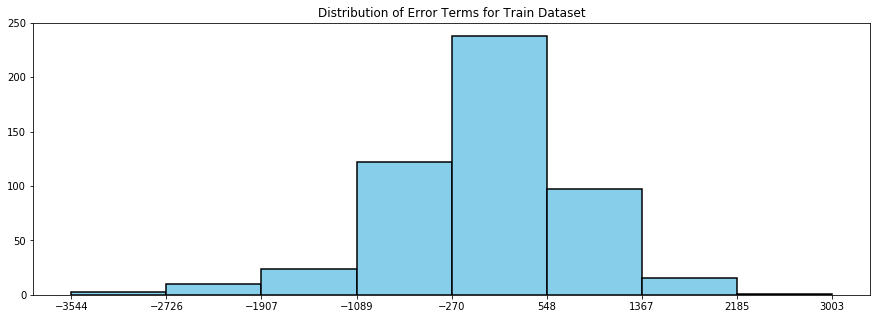

In [94]:
res_train = y_train - y_train_predict
plt.figure(figsize = (15, 5))
plt.title('Distribution of Error Terms for Train Dataset')
_, bins, _ = plt.hist(res_train, bins = 8, color = 'skyblue', edgecolor = 'black', linewidth = 1.5)
plt.xticks(bins)
plt.show()

#### The error terms are normally distributed.

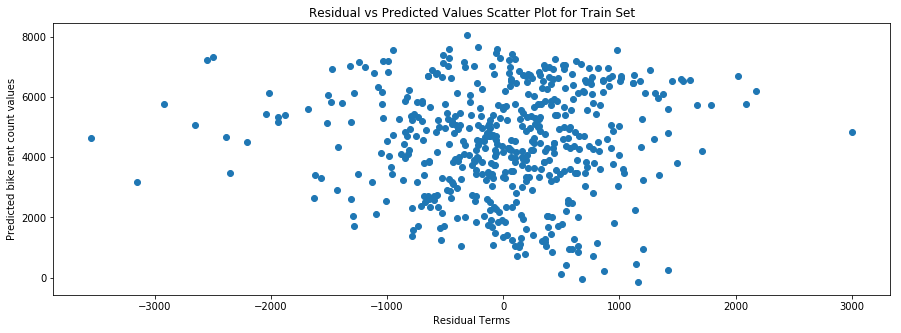

In [95]:
plt.figure(figsize = (15, 5))
plt.title('Residual vs Predicted Values Scatter Plot for Train Set')
plt.xlabel('Residual Terms')
plt.ylabel('Predicted bike rent count values')
plt.scatter(res_train, y_train_predict)
plt.show()

#### There is no pattern in the residual and predicted values, hence homoscedasticity holds.

In [96]:
rse_trn = np.sqrt(mean_squared_error(y_train, y_train_predict))
print('RSE for Train Dataset:', rse_trn)

RSE for Train Dataset: 794.3154712723688


# Let us finalize model 9 (R-squared = 0.834).

# Making predictions on the test set

In [97]:
X_test_sm = sm.add_constant(X_test_sc[sel_cols])
y_test_predict = lr_m9.predict(X_test_sm).values.reshape((-1, 1))
r2_tst = r2_score(y_test, y_test_predict)
print('R-Squared for Test Dataset:', r2_tst)

R-Squared for Test Dataset: 0.7935224695104377


In [98]:
rse_tst = np.sqrt(mean_squared_error(y_test, y_test_predict))
print('RSE for Test Dataset:', rse_tst)

RSE for Test Dataset: 863.6443263359793


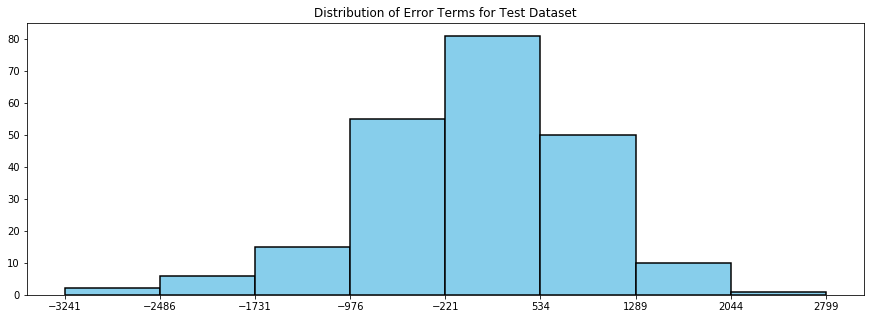

In [99]:
res_test = y_test - y_test_predict
plt.figure(figsize = (15, 5))
plt.title('Distribution of Error Terms for Test Dataset')
_, bins, _ = plt.hist(res_test, bins = 8, color = 'skyblue', edgecolor = 'black', linewidth = 1.5)
plt.xticks(bins)
plt.show()

#### The error terms are normally distributed.

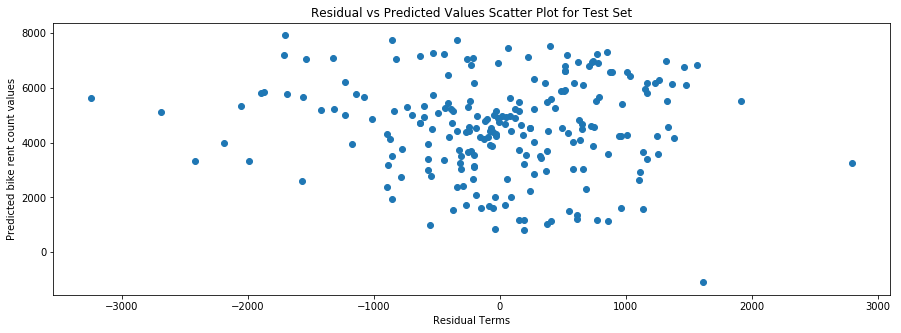

In [100]:
plt.figure(figsize = (15, 5))
plt.title('Residual vs Predicted Values Scatter Plot for Test Set')
plt.xlabel('Residual Terms')
plt.ylabel('Predicted bike rent count values')
plt.scatter(res_test, y_test_predict)
plt.show()

#### There is no pattern in the residual and predicted values, hence homoscedasticity holds.

### Using Automatic Feature Selection, we obtained the same results as with Manual Feature Selection. Also, the assumptions of Multiple Linear Regression are also true for our model. Therefore we can use this model to understand how various independent factors affect the count of bikes on a single day.

# Final Model Equation

Cnt = 1158.2383 + (4496.6820 * Temp) + (2021.4376 * Yr) + (1191.5878 * Winter) + (1010.8056 * Sep) + (879.7754 * Summer) +  (470.5913 * Aug) - (705.2619 * Cloudy) - (839.4338 * Holiday) - (1301.2697 * WindSpeed) - (2449.8560 * LightRain)